#EE20B072

#EE20B043

In [19]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [20]:
!pip install snntorch

In [21]:
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [22]:
batch_size = 128
data_path='/tmp/data/emnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [23]:
transform = transforms.Compose([transforms.Resize((28, 28)),transforms.Grayscale(),transforms.ToTensor(),transforms.Normalize((0,), (1,))])
emnist_train = datasets.EMNIST(data_path, split='balanced', train=True, download=True, transform=transform)
emnist_test = datasets.EMNIST(data_path, split='balanced', train=False, download=True, transform=transform)
train_loader = DataLoader(emnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(emnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [24]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

In [25]:
#  Initialize Network
net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(64*4*4, 47),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [26]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

for step in range(num_steps):
    spk_out, mem_out = net(data)

In [27]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)
  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)
  return torch.stack(spk_rec), torch.stack(mem_rec)

In [28]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

In [29]:
loss_fn = SF.ce_count_loss()

In [30]:
loss_val = loss_fn(spk_rec, targets)

print(f"The loss from an untrained network is {loss_val.item():.3f}")

The loss from an untrained network is 3.850


In [31]:
acc = SF.accuracy_rate(spk_rec, targets)

print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The accuracy of a single batch using an untrained network is 2.344%


In [32]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [33]:
def test_results(test_loader, net, num_steps):
  test_accuracy = batch_accuracy(test_loader, net, num_steps)
  print(f"The total accuracy on the test set is: {test_accuracy * 100:.2f}%")

In [34]:
optimizer = torch.optim.Adam(net.parameters(), lr=3e-3, betas=(0.99, 0.999))
num_epochs = 8
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        counter += 1

    # Test set at the end of the epoch
    with torch.no_grad():
        net.eval()

        # Test set forward pass
        test_acc = batch_accuracy(test_loader, net, num_steps)
        print(f"Epoch {epoch + 1}, Test Acc: {test_acc * 100:.2f}%\n")
        test_acc_hist.append(test_acc.item())


Epoch 1, Test Acc: 77.47%

Epoch 2, Test Acc: 79.75%

Epoch 3, Test Acc: 80.43%

Epoch 4, Test Acc: 80.15%

Epoch 5, Test Acc: 82.06%

Epoch 6, Test Acc: 82.08%

Epoch 7, Test Acc: 81.73%

Epoch 8, Test Acc: 80.82%



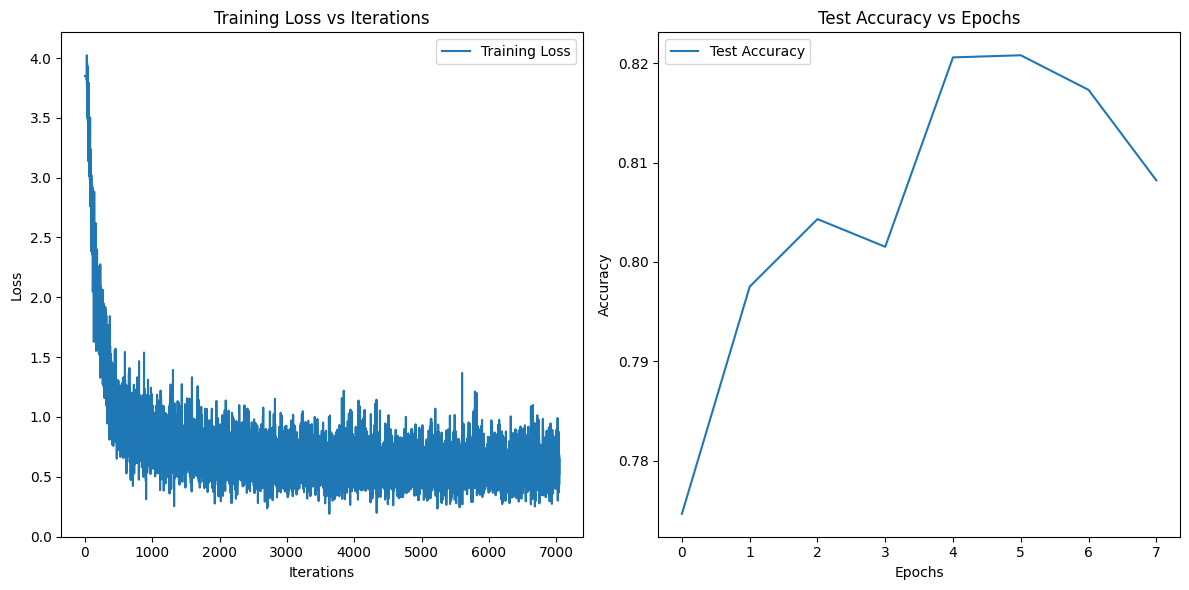

In [35]:
import matplotlib.pyplot as plt

# Plotting training loss vs epoch
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss vs Iterations')
plt.legend()

# Plotting test accuracy vs epoch
plt.subplot(1, 2, 2)
plt.plot(test_acc_hist, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [36]:
test_results(test_loader, net, num_steps)

The total accuracy on the test set is: 80.81%
